In [72]:
from transformers import pipeline
import nltk
from nltk import sent_tokenize
import torch
from glob import glob
import pandas as pd
import numpy as np

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yazan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Model

In [3]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else "cpu"

In [4]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )
    return theme_classifier

In [7]:
theme_classifier = load_model(device)

c:\Users\Yazan\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

c:\Users\Yazan\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Yazan\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
theme_list = ["friendship", "hope","sacrifice","battle", "self development","batrayal", "love", "dialogue"]

In [8]:
theme_classifier(
    "I gave him a right hook then a left jab",
    theme_list,
    multi_label=True
)

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['battle',
  'batrayal',
  'self development',
  'hope',
  'sacrifice',
  'dialogue',
  'love',
  'friendship'],
 'scores': [0.912125289440155,
  0.5287171602249146,
  0.47500282526016235,
  0.08781789243221283,
  0.045000530779361725,
  0.020133044570684433,
  0.004292435944080353,
  0.002817211439833045]}

# Load Dataset

In [10]:
files = glob('../data/Subtitles/*.ass')

In [11]:
files[:5]

['../data/Subtitles\\Naruto Season 1 - 01.ass',
 '../data/Subtitles\\Naruto Season 1 - 02.ass',
 '../data/Subtitles\\Naruto Season 1 - 03.ass',
 '../data/Subtitles\\Naruto Season 1 - 04.ass',
 '../data/Subtitles\\Naruto Season 1 - 05.ass']

In [29]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    lines = lines[27:] # first lines are metadata
    lines = [",".join(line.split(',')[9:]) for line in lines]


In [30]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [31]:
# cleaning text
lines = [line.replace('\\N', ' ') for line in lines]

In [32]:
lines[:2]

['A long time ago, a powerful demon fox appeared with nine tails.\n',
 'With its powerful tails,\n']

In [33]:
" ".join(lines[:10])

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n"

In [34]:
# extracting eposide number from file path
int(files[0].split('-')[-1].split('.')[0].strip())

1

In [55]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path+'/*.ass')

    scripts=[]
    episode_num=[]

    for path in subtitles_paths:

        #Read Lines
        with open(path,'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines =  [ ",".join(line.split(',')[9:])  for line in lines ]
        
        lines = [ line.replace('\\N',' ') for line in lines]
        script = " ".join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode":episode_num, "script":scripts })
    return df

In [56]:
dataset_path = "../data/Subtitles"
df = load_subtitles_dataset(dataset_path)

In [58]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


# Run Model

In [60]:
script = df.iloc[0].script
script

'A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can\'t let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you! Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here, lruka Sensei?\n The question is what are you doing here when you should 

In [61]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [63]:
# Batch sentences 
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)
    

In [66]:
script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [67]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label= True
)

In [68]:
theme_output

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'battle',
   'sacrifice',
   'self development',
   'batrayal',
   'hope',
   'friendship',
   'love'],
  'scores': [0.9800741672515869,
   0.8546884059906006,
   0.7349809408187866,
   0.7284971475601196,
   0.3902464509010315,
   0.199098125100135

In [70]:
# Wrangl output
# battle = [0.322332, 0.324154,...]
themes = {}
for output in theme_output:
    for label, score in zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [71]:
themes

{'dialogue': [0.9800741672515869, 0.9370126724243164],
 'battle': [0.8546884059906006, 0.6581318378448486],
 'sacrifice': [0.7349809408187866, 0.6258839964866638],
 'self development': [0.7284971475601196, 0.8678207397460938],
 'batrayal': [0.3902464509010315, 0.5286831259727478],
 'hope': [0.1990981251001358, 0.20424041152000427],
 'friendship': [0.05922327935695648, 0.08603352308273315],
 'love': [0.04026176780462265, 0.028020499274134636]}

In [78]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)
    # Batch sentences 
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)

    # Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label= True
        )   
    # Wrangl output
    # battle = [0.322332, 0.324154,...]
    themes = {}
    for output in theme_output:
        for label, score in zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.array(value).mean() for key, value in themes.items()}

    return themes

In [79]:
df = df.head(2)

In [86]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [81]:
output_themes = df['script'].apply(get_themes_inference)

In [82]:
output_themes

0    {'dialogue': 0.9585434198379517, 'battle': 0.7...
1    {'dialogue': 0.9606060087680817, 'sacrifice': ...
Name: script, dtype: object

In [83]:
theme_df = pd.DataFrame(output_themes.tolist())

In [84]:
theme_df

,dialogue,battle,sacrifice,self development,batrayal,hope,friendship,love
0,0.958543,0.756410,0.680432,0.798159,0.459465,0.201669,0.072628,0.034141
1,0.960606,0.684846,0.570703,0.482810,0.483199,0.154533,0.046261,0.173261


In [87]:
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [90]:
df[theme_df.columns] = theme_df
df

C:\Users\Yazan\AppData\Local\Temp\ipykernel_8992\3417989627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[theme_df.columns] = theme_df


,episode,script,dialogue,battle,sacrifice,self development,batrayal,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.958543,0.756410,0.680432,0.798159,0.459465,0.201669,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.960606,0.684846,0.570703,0.482810,0.483199,0.154533,0.046261,0.173261


# Visualize output

In [92]:
df = df.drop('dialogue', axis=1)

In [96]:
theme_output = df.drop(['episode', 'script'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,battle,1.441256
1,sacrifice,1.251136
2,self development,1.280969
3,batrayal,0.942663
4,hope,0.356203
5,friendship,0.118889
6,love,0.207402


In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

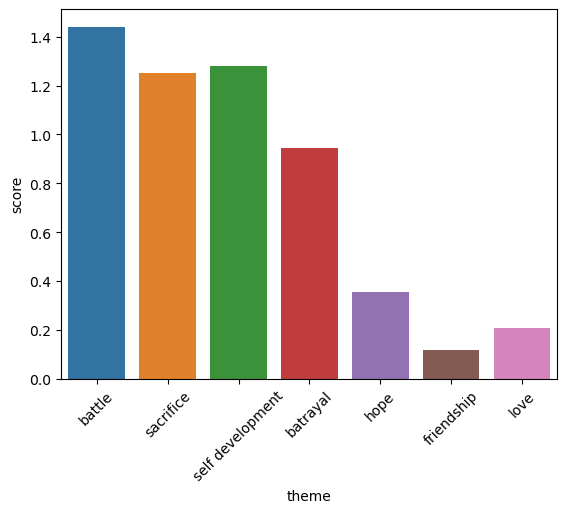

In [101]:
sns.barplot(data=theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()